# UncertainTaggerBuilderTest

Ad-hoc testing for the UncertainTaggerBuilder class.

In [1]:
import os
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from MotifFeatures.UncertainTaggerBuilder import UncertainTaggerBuilder
from MotifFeatures.Labels.BIOELabel import BIOELabel

In [2]:
train_path = os.path.join('datasets', 'occ_45K_train.pickle')
with open(train_path, 'rb') as dbfile:
    train = pickle.load(dbfile)
motifs_path = os.path.join(
    'MotifFeatures', 'MotifGopher',
    'Gopher_01-49PM_21_Mar_2021_motifs.pickle')
with open(motifs_path, 'rb') as dbfile:
    motifs = pickle.load(dbfile)

In [3]:
def tag_matrix(dataset, textgetter, entitygetter):
    """Return a four-column dataframe of the BIOELabel output for
    matches to the entity returned by entitygetter.
    """
    data = {tag: [] for tag in ('raw', 'B', 'I', 'O', 'E')}
    def process(row):
        data['raw'].append(textgetter(row))
        for tag, value in BIOELabel(
                textgetter(row), entitygetter(row)).tags().items():
            data[tag].append(value)
    dataset.apply(process, axis=1)
    return pd.DataFrame(data)
author_tags_path = os.path.join('datasets', 'author_tags_scratch.pickle')
if not os.path.exists(author_tags_path):
    t0 = time.time()
    author_tags = tag_matrix(
        train, lambda row: row.raw, lambda row: row.author.surnames()
    )
    print('Author tags generated in {:.2f} seconds.'.format(
        time.time() - t0))
    with open(author_tags_path, 'ab') as dbfile:
        pickle.dump(author_tags, dbfile, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(author_tags_path, 'rb') as dbfile:
        author_tags = pickle.load(dbfile)
author_tags.head()

,raw,B,I,O,E
0,"Knechtle, B, Knechtle, P, Schulze, I, Kohler, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Sousa, M, Fernandes, MJ, Moreira, P, Teixeira,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"Schooler, J. (2011). Unpublished results hide ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,"Melin, A, Tornberg, AB, Skouby, S, Moller, SS,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,"Schenk, K, Faulhaber, M, Gatterer, H, Burtsche...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [7]:
sample = author_tags.sample(1000)
t0 = time.time()
utb = UncertainTaggerBuilder(
    texts=sample.raw, tags=sample.B, motifs=motifs, sort_sample_size=100)
print('Time to initialize:', time.time() - t0)

Time to initialize: 0.012528419494628906


In [5]:
while True:
    t0 = time.time()
    utb.improve()
    print('Elapsed time: {}\nCount of states assessed: {}\n'
        'Count of OOB scores calculated: {}\nMax OOB: {}\n'
        'Latest OOB: {}\n'.format(
            time.time() - t0,
            len(utb._states),
            sum(1 if utb._states[f].oob_score else 0 for f in utb._states),
            utb._max_oob,
            utb.scores[-1]))

Backend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
Elapsed time: 2.5177114009857178
Count of states assessed: 8
Count of OOB scores calculated: 8
Max OOB: 0.2060167545484759

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
Elapsed time: 3.0130512714385986
Count of states assessed: 9
Count of OOB scores calculated: 9
Max OOB: 0.2060167545484759

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
Elapsed time: 2.5298104286193848
Count of states assessed: 10
Count of OOB scores calculated: 10
Max OOB: 0.2060167545484759

[Parallel(n_jobs=-1)]: Using b

KeyboardInterrupt: 

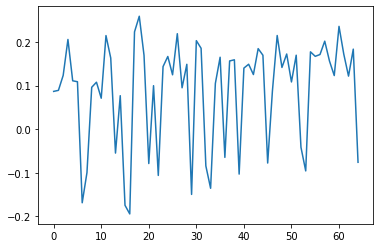

In [6]:
plt.plot(utb.scores)

In [24]:
len(utb._states)

12143

In [21]:
z_scores = [utb._is_promising(f) for f in utb._states]

In [25]:
len([a for a in z_scores if a > 3])

4

(array([11., 11.,  4.,  3., 10., 12.,  3.,  9.,  6.,  9.]),
 array([1.23044393, 1.41083148, 1.59121903, 1.77160658, 1.95199413,
        2.13238168, 2.31276923, 2.49315679, 2.67354434, 2.85393189,
        3.03431944]),
 <BarContainer object of 10 artists>)

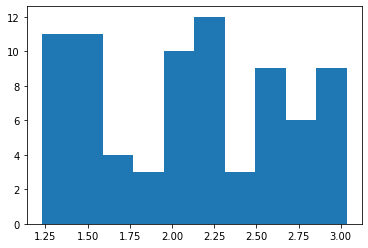

In [27]:
plt.hist(z_scores)

In [7]:
utb._max_oob

0.8538786389410344

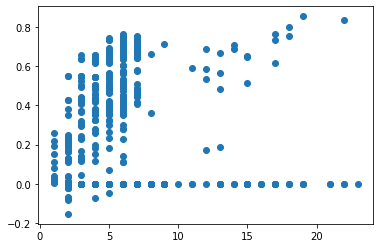

In [10]:
lengths = []
oobs = []
for fset in utb._states:
    lengths.append(len(fset))
    oobs.append(utb._states[fset].oob_score if utb._states[fset].oob_score else 0)
plt.scatter(lengths, oobs);

(array([ 1.,  0.,  3.,  3.,  4.,  8.,  8.,  7., 10., 20., 16., 15., 10.,
         6., 14.,  9.,  2.,  7.,  8., 12., 12., 17.,  9.,  8.,  6.,  4.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.6       , 0.60612245, 0.6122449 , 0.61836735, 0.6244898 ,
        0.63061224, 0.63673469, 0.64285714, 0.64897959, 0.65510204,
        0.66122449, 0.66734694, 0.67346939, 0.67959184, 0.68571429,
        0.69183673, 0.69795918, 0.70408163, 0.71020408, 0.71632653,
        0.72244898, 0.72857143, 0.73469388, 0.74081633, 0.74693878,
        0.75306122, 0.75918367, 0.76530612, 0.77142857, 0.77755102,
        0.78367347, 0.78979592, 0.79591837, 0.80204082, 0.80816327,
        0.81428571, 0.82040816, 0.82653061, 0.83265306, 0.83877551,
        0.84489796, 0.85102041, 0.85714286, 0.86326531, 0.86938776,
        0.8755102 , 0.88163265, 0.8877551 , 0.89387755, 0.9       ]),
 <BarContainer object of 49 artists>)

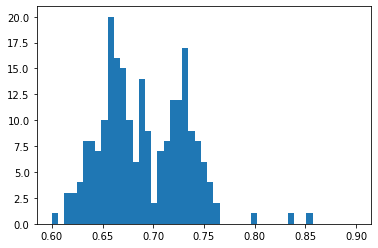

In [13]:
import numpy as np
plt.hist(oobs, bins=np.linspace(0.6, 0.9, 50))

In [14]:
utb._CV(utb._features[:30])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.1s finished
DEBUG: pred:  [0.86 0.01 0.01 0.   0.   0.   0.   0.02 0.   0.   0.86 0.   0.   0.
 0.   0.   0.   0.   0.   0.21]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.8989935298346513
DEBUG: recall:  0.8702157272094642
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_job

(0.8771707103557901, 0.8775143577984751)

In [19]:
naive_best = [f for f in utb._features if not hasattr(f, '_i') or f._i in (-1, 0)][:30]
utb._CV(naive_best)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.9s finished
DEBUG: pred:  [0.91 0.03 0.01 0.01 0.01 0.01 0.01 0.19 0.   0.   0.55 0.02 0.02 0.02
 0.01 0.01 0.   0.   0.   0.1 ]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.8465384615384616
DEBUG: recall:  0.7658315935977731
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_j

(0.8172467696505186, 0.817884952991671)

In [18]:
[str(f) for f in utb._features[:30]]

['FORWARDPositionFeature',
 '-1th_" "',
 '0th_" "',
 '-1th_", "',
 '0th_", "',
 '1th_"e"',
 '-2th_"e"',
 '1th_"s"',
 '-2th_"."',
 '-2th_", "',
 '2th_"l"',
 '2th_"c"',
 '2th_"e "',
 '2th_" "',
 '-3th_", "',
 '-3th_"."',
 '2th_": "',
 '2th_". "',
 '2th_"n"',
 '2th_"e"',
 '2th_"r"',
 '2th_"s"',
 '-3th_"e"',
 '2th_"t"',
 '2th_"d"',
 '2th_"i"',
 '-3th_" "',
 '1th_", "',
 '-2th_"n"',
 '1th_"a"']

In [15]:
max(utb._states[f].cv_score for f in utb._states if utb._states[f].cv_score)

(0.8981218352971807, 0.8983532051214338)

got 465 fsets
got z scores


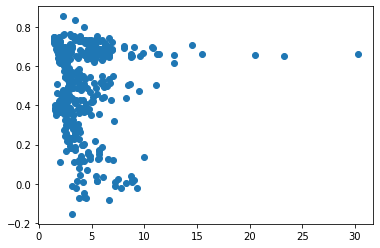

In [29]:
import random
fsets = list(f for f in utb._states.keys() if utb._states[f].oob_score)
print('got {} fsets'.format(len(fsets)))
def z_score(seq):
    return (utb._max_oob - np.mean(seq)) / np.std(seq)
z_scores = [
    z_score([utb._states[other].oob_score
    for other in utb._k_most_similar(10, f)]) for f in fsets
]
print('got z scores')
oob_scores = [utb._states[f].oob_score for f in fsets]
plt.scatter(z_scores, oob_scores);

In [31]:
import scipy
scipy.stats.pearsonr(z_scores, oob_scores)

(-0.028953523151053276, 0.5334160759122355)

In [41]:
rank_orders = [np.mean([utb._features.index(f) for f in fset if not hasattr(f, '_i') or f._i in (0, 1)]) for fset in fsets]

/home/pdonovan/Documents/awca/CitationParser/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pdonovan/Documents/awca/CitationParser/env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


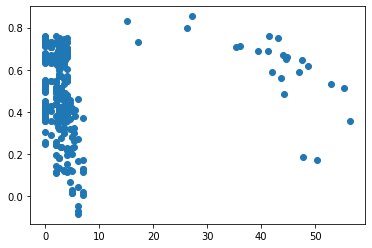

In [42]:
plt.scatter(rank_orders, oob_scores)

In [43]:
scipy.stats.pearsonr(rank_orders, oob_scores)

ValueError: array must not contain infs or NaNs

In [32]:
bad = [f for f in utb._states if utb._states[f].oob_score and utb._states[f].oob_score < 0.1]
bad

[frozenset({<MotifFeatures.MotifFeature.MotifFeature at 0x7f862903d1c0>})]

In [33]:
[str(f) for f in bad[0]]

['-1th_" "']

In [36]:
good = [f for f in utb._states if utb._states[f].oob_score and utb._states[f].oob_score > 0.8]
len(good)

7

In [40]:
strange = [f for f in good if utb._is_promising(f) > 2]
print(len(strange))
[[str(f) for f in strange[i]] for i in range(len(strange))]

1


[['-2th_"n"',
  '-1th_", "',
  '-2th_", "',
  '-2th_"."',
  '1th_"o"',
  'FORWARDPositionFeature',
  '-2th_"e"',
  '-1th_" "',
  '-2th_" "',
  '1th_"3"',
  '1th_"t"',
  '1th_"n"',
  '-2th_"r"',
  '1th_"i"',
  '1th_"n "',
  '1th_". "',
  '1th_"c"',
  '1th_"."',
  '1th_"e"']]

In [6]:
[str(f) for fset in utb._states for f in fset if f not in utb._importances]

[]

In [18]:
utb._knn_z

1

In [6]:
len(utb._states)

18

In [7]:
utb._max_oob

0.7774467299084082

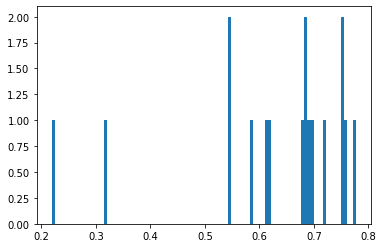

In [8]:
plt.hist([utb._states[f].oob_score for f in utb._states if utb._states[f].oob_score], bins=100);

In [9]:
for f in utb._features:
    try:
        if f._i not in (-1, 0): print(f._i)
    except:
        pass

-2
1
1
-2
1
1
-2
1
-2
-2
-2
1
1
1
1
1
1
-2
1
1
1


In [11]:
utb._features[1].successor() in utb._features

True

In [10]:
poor = [fset for fset in utb._states if utb._states[fset].oob_score and utb._states[fset].oob_score < 0.5]

In [11]:
chosen = poor[-1]
similar = utb._k_most_similar(20, chosen)
scores = [utb._states[fset].oob_score for fset in similar]
print(utb._states[chosen].oob_score)
scores

0.31886593484298187


[0.6193349898754159,
 0.7591890944245097,
 0.6919342012514993,
 0.21894089554461638,
 0.6806882569744354,
 0.7505043691713058,
 0.6871238979986042,
 0.5478109130225598,
 0.5862788770592133,
 0.6869085851649555,
 0.7774467299084082,
 0.7179121191656342,
 0.544616137228453,
 0.7515731794514993,
 0.6942401379458117,
 0.6152166872788812,
 0.31886593484298187]

In [12]:
import numpy as np
np.mean(scores), np.std(scores)

(0.6263873533122815, 0.1483904442991179)

In [13]:
from MotifFeatures.Utils.algs import set2vec
print(list(set2vec(utb._features[:10], chosen,
                        weights=utb._importances)))
print()
for fset in similar:
    print(list(set2vec(utb._features[:10], fset,
                        weights=utb._importances)))

[0.0, 0.08587898015384482, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.0676561340460158, 0.1250475056169679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22658080238398962, 0.0, 0.0, 0.1250475056169679, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22658080238398962, 0.0, 0.0, 0.1250475056169679, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22658080238398962, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22658080238398962, 0.0, 0.0, 0.1250475056169679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22658080238398962, 0.08587898015384482, 0.0676561340460158, 0.0, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0676561340460158, 0.1250475056169679, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.08587898015384482, 0.0676561340460158, 0.1250475056169679, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.08587898015384482, 0.0, 0.0, 0.11564928346750024, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.08587898015384482, 0.0676561340460158, 0.1250475056169679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0

In [14]:
import scipy
[scipy.spatial.distance.cosine(
                    set2vec(utb._features[:10], chosen,
                        weights=utb._importances),
                    set2vec(utb._features[:10], other,
                        weights=utb._importances)
                ) for other in similar]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6898405636418887,
 1.0,
 0.575688592647668,
 0.40381878425306306,
 0.4829702758638533,
 0.6898405636418887,
 0.6586385402444711,
 0.575688592647668,
 0.6898405636418887,
 0.7100497614323652,
 0.0,
 0.0]

In [6]:
for featureset in utb._states:
    print(utb._states[featureset].oob_score, utb._states[featureset].cv_score)

0.26510773187279346 (0.402335900541211, 0.40256882149915657)
0.19819044800079322 (nan, nan)
0.07999646632752189 (nan, nan)
0.11327987396502193 (0.021195492638121156, 0.022713442004527497)
0.22461335926410642 (nan, nan)
0.5650789219691059 (0.6222504459320146, 0.6230137812418679)
0.43627532970620764 (0.4666241591735091, 0.46829339465235476)
0.4358428132614023 (0.4660184105484766, 0.4676473655844936)
0.5642444568586058 (0.6201208036592976, 0.6207578351395246)
0.2187618538570537 (nan, nan)
0.24934546205953845 (0.010218200074972907, 0.011043197014926232)
0.22461335926410642 (nan, nan)
0.11327987396502193 (0.010218200074972907, 0.011043197014926232)
0.2405913172333075 (0.016385663345129316, 0.016995691461710358)
0.24899730631908457 (0.04919110865041069, 0.050477691711668195)
0.5658429706335987 (0.6201035423458765, 0.620937651358767)
0.5653842049500402 (0.6197433716929419, 0.6205361979056998)
0.5642132688059753 (0.6201208036592976, 0.6207578351395246)
0.4358444264007031 (0.4650557680078522, 0

In [24]:
for f in utb._states:
    if utb._states[f].oob_score > 0.5:
        print(len(f), end=': ')
        print([str(el) if hasattr(el, '_motif') else 'p?' for el in f], end=' => ')
        print(utb._states[f].mean_cv())

2: ['-1th_", "', 'p?'] => 0.6226321135869413
2: ['0th_", "', 'p?'] => 0.6204393193994111
3: ['-1th_", "', '-1th_" "', 'p?'] => 0.6205205968523217
3: ['-1th_", "', '0th_" "', 'p?'] => 0.6201397847993209
3: ['0th_", "', '-1th_", "', 'p?'] => 0.6204393193994111
3: ['0th_", "', '-1th_" "', 'p?'] => 0.6186201606430113
3: ['0th_", "', '0th_" "', 'p?'] => 0.6181642390672507
4: ['-1th_", "', '0th_" "', '-1th_" "', 'p?'] => 0.6199599871477911
4: ['0th_", "', '-1th_", "', '-1th_" "', 'p?'] => 0.6179021677758658
4: ['0th_", "', '-1th_", "', '0th_" "', 'p?'] => 0.6168508667161314
4: ['0th_", "', '0th_" "', '-1th_" "', 'p?'] => 0.6170933294308887
5: ['0th_", "', '0th_" "', 'p?', '-1th_", "', '-1th_" "'] => 0.6163652478685634


In [18]:
for f in utb._features[:45]:
    try:
        print(str(f))
    except:
        print(repr(f))
        pass

-1th_", "
-1th_" "
0th_" "
0th_", "
0th_". "
0th_"r"
0th_"a"
0th_"e"
0th_"."
0th_"i"
0th_"s"
0th_"t"
0th_"n"
0th_"o"
0th_"2"
0th_"c"
0th_"1"
0th_"u"
0th_"d"
-1th_"e"
0th_"l"
0th_"m"
0th_"n "
0th_": "
0th_"s "
0th_"0"
-1th_"a"
0th_"in"
0th_"h"
0th_" a"
0th_"ID: "
0th_"f"
0th_"ti"
0th_"3"
0th_"D: "
-1th_" H"
0th_"6"
0th_"y"
-1th_"M, "
0th_"e "
0th_"MID: "
0th_" P"
0th_"9"


In [5]:
import scipy
utb._CV(utb._features[:5], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   11.5s finished
DEBUG: pred:  [0.82 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.   0.   0.18 0.   0.   0.01]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.7143437132069343
DEBUG: recall:  0.7024793388429752
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_job

(0.7076130676909922, 0.7078092812415084)

In [6]:
utb._CV(utb._features[:15], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   13.3s finished
DEBUG: pred:  [0.89 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.9061658129387213
DEBUG: recall:  0.9567725652017147
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_job

(0.9314494071872645, 0.9317887091104284)

In [7]:
utb._CV(utb._features[:30], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 49.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   14.4s finished
DEBUG: pred:  [0.82 0.   0.01 0.01 0.   0.   0.   0.   0.   0.92 0.   0.   0.   0.
 0.   0.   0.01 0.   0.   0.86]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
DEBUG: precision:  0.9153475567790778
DEBUG: recall:  0.957753240518483
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 47.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs

(0.9344782094887113, 0.9346239206612587)

In [8]:
utb._CV(utb._features[:60], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 51.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   23.5s finished
DEBUG: pred:  [0.87 0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.   0.   0.91 0.
 0.01 0.   0.   0.   0.01 0.  ]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.913816425120773
DEBUG: recall:  0.949140976236352


KeyboardInterrupt: 

In [6]:
[str(feature) for feature in utb._features[:10]]

['-1th_", "',
 '0th_", "',
 '0th_" "',
 '0th_". "',
 '-1th_"J, "',
 '-1th_" "',
 '-1th_"H, "',
 '-1th_" S"',
 '-1th_" K"',
 '-1th_" W"']

In [5]:
X, y = utb._X(), utb._labels()

In [26]:
regr = RandomForestRegressor(
    random_state=0, verbose=1, n_jobs=-1)

In [27]:
t0 = time.time()
regr.fit(X, y)
print('Elapsed time:', time.time() - t0)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.8min
Elapsed time: 593.4815990924835
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  9.9min finished


In [30]:
[
    X.columns[idx] + ' -> ' + str(regr.feature_importances_[idx])
    for idx in range(len(X.columns))
    if regr.feature_importances_[idx] > 0.0014
]

['-1th_"i" -> 0.03139330469785673',
 '-1th_" " -> 0.030653403690900877',
 '-1th_"r" -> 0.002516241148017014',
 '-1th_"e" -> 0.05082396238975671',
 '-1th_"n" -> 0.004698896506257944',
 '-1th_"a" -> 0.04924226826706511',
 '-1th_"t" -> 0.00352795080863393',
 '-1th_"s" -> 0.005556928071292358',
 '-1th_"o" -> 0.03615993932352817',
 '-1th_". " -> 0.031609844380332396',
 '-1th_"." -> 0.0015290126610194186',
 '-1th_", " -> 0.1252682644062291',
 '-1th_"u" -> 0.015811471513609097',
 '-1th_"h" -> 0.0062621085694191',
 '-1th_"m" -> 0.0014475392387895741',
 '-1th_"M" -> 0.0024070756119629966',
 '-1th_"e " -> 0.005769372641047589',
 '-1th_"y" -> 0.005068830645877607',
 '-1th_"S" -> 0.004563153390237448',
 '-1th_"A" -> 0.0026830181413667734',
 '-1th_"C" -> 0.002325269359642735',
 '-1th_"J" -> 0.003336292566078514',
 '0th_"i" -> 0.025638028692881412',
 '0th_" " -> 0.08368215974583824',
 '0th_"r" -> 0.014615038521526562',
 '0th_"e" -> 0.02441914534215503',
 '0th_"n" -> 0.002964311322686968',
 '0th_"a" 

(array([133.,  30.,   7.,   4.,   5.,   1.,   1.,   0.,   1.,   1.,   1.,
          3.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   0.,   1.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00140581, 0.00281162, 0.00421743, 0.00562323,
        0.00702904, 0.00843485, 0.00984066, 0.01124647, 0.01265228,
        0.01405808, 0.01546389, 0.0168697 , 0.01827551, 0.01968132,
        0.02108713, 0.02249293, 0.02389874, 0.02530455, 0.02671036,
        0.02811617, 0.02952198, 0.03092778, 0.

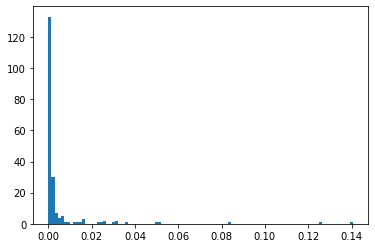

In [28]:
plt.hist(regr.feature_importances_, bins=100)

(array([ 92., 395., 113.,  69.,  57.,  30.,  30.,  19.,  16.,  28.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

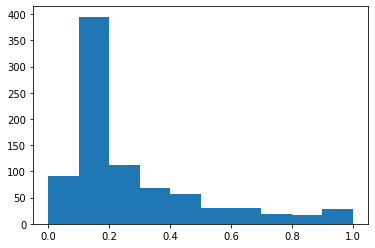

In [37]:
import random
frequencies = set()
sample_raws = set(author_tags.raw)
for motif in motifs:
    frequencies.add(
        sum(1 if motif in text else 0 for text in sample_raws)
        / len(sample_raws))
plt.hist(frequencies)

In [38]:
len(sample_raws)

33292